This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week5` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 5.2. Clustering.

In this problem, we will continue from where we left off in Problem 5.1, and apply k-means clustering algorithm on Delta Airline's aircrafts.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


I saved the `reduced` array (the first 10 principal components of the Delta Airline data set) from Problem 8.1 as a `npy` file.

```python
>>> np.save('delta_reduced.npy', reduced)
```

This file is in `/home/data_scientist/data/misc`. We will load this file as a Numpy array and start from there.

In [2]:
reduced = np.load('/home/data_scientist/data/misc/delta_reduced.npy')

# k-means

- Write a function named `cluster()` that fits a k-means clustering algorithm, and returns a tuple `(sklearn.cluster.k_means_.KMeans, np.array)`. The second element of the tuple is a 1-d array that contains the predictions of k-means clustering, i.e. which cluster each data point belongs to.

Use default values for all parameters in `KMeans()` execept for `n_clusters` and `random_state`.

In [3]:
def cluster(array, random_state, n_clusters=4):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    array: A numpy array
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    
    # YOUR CODE HERE
    model = KMeans(n_clusters=n_clusters, random_state=random_state)
    model.fit(array)
    clusters = model.predict(array)
    
    return model, clusters

In [4]:
k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(1), n_clusters=5)

assert_is_instance(k_means_t, sklearn.cluster.k_means_.KMeans)
assert_is_instance(cluster_t, np.ndarray)
assert_equal(k_means_t.n_init, 10)
assert_equal(k_means_t.n_clusters, 5)
assert_equal(len(cluster_t), len(reduced))
assert_true((cluster_t < 5).all()) # n_cluster = 5 so labels should be between 0 and 5
assert_true((cluster_t >= 0).all())
labels_gold = -1. * np.ones(len(reduced), dtype=np.int)
mindist = np.empty(len(reduced))
mindist.fill(np.infty)
for i in range(5):
    dist = np.sum((reduced - k_means_t.cluster_centers_[i])**2., axis=1)
    labels_gold[dist < mindist] = i
    mindist = np.minimum(dist, mindist)
assert_true((mindist >= 0.0).all())
assert_true((labels_gold != -1).all())
assert_array_equal(labels_gold, cluster_t)

## The elbow method

Now, we would like to apply the k-means clustering technique, but how do we determine k, the number of clusters?

The simplest method is [the elbow method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method), which is similar to what we did in Problem 5.1. But what criterion should we use, i.e. what should go on the y-axis?

According to [scikit-learn documentation](http://scikit-learn.org/stable/modules/clustering.html#k-means),

```
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance,
minimizing a criterion known as the inertia or within-cluster sum-of-squares.
```

The scikit-learn documentation on [sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn-cluster-kmeans) says that `sklearn.cluster.KMeans` has the inertia value in the `inertia_` attribute. So we can vary the number of clusters in `KMeans`, plot `KMeans.inertia_` as a function of the number of clusters, and pick the "elbow" in the plot.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/elbow.png)

Always use `check_random_state(0)` to seed the random number generator.

In [5]:
def plot_inertia(array, start=1, end=10):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.
    
    Parameters
    ----------
    array: A numpy array.
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    # YOUR CODE HERE
    clusters = np.arange(start, end+1, 1)
    length = len(clusters)
    inertis = np.zeros(length)
    for i in range(length):
        model = KMeans(n_clusters=clusters[i], random_state=check_random_state(0))
        model.fit(array)
        inertis[i] = model.inertia_  
        
    sns.set_style("white")
    fig, ax = plt.subplots()
    plt.plot(clusters, inertis)
    plt.hold('on')
    plt.plot(4, inertis[3], 'r.', markersize=30, alpha=0.6)
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertis')
    ax.set_xlabel('Number of clusters')
    sns.despine()
    
    return ax

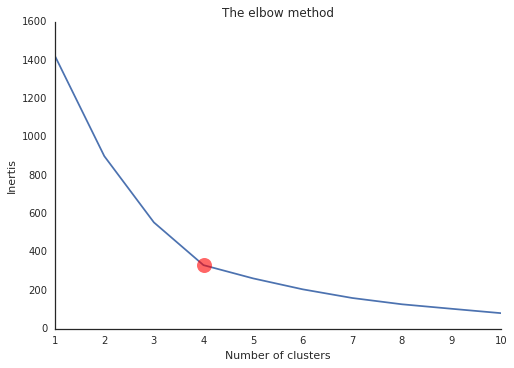

In [6]:
inertia = plot_inertia(reduced)

In [7]:
assert_is_instance(inertia, mpl.axes.Axes)
assert_true(len(inertia.lines) >= 1)

xdata, ydata = inertia.lines[0].get_xydata().T

for i in range(1, 11):
    k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(0), n_clusters=i)
    assert_array_equal(xdata[i - 1], i)
    assert_almost_equal(ydata[i - 1], k_means_t.inertia_)

assert_is_not(len(inertia.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(inertia.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(inertia.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

## Pair Grid

- Write a function named `plot_pair()` that uses [seaborn.PairGrid](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.PairGrid.html#) to visualize the clusters in terms of first four principal components. The plots on the diagonal should be histograms of corresponding attributes, and the off-diagonal should be scatter plots.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/pca_pair_plot.png)

In [8]:
def plot_pair(reduced, clusters):
    '''
    Uses seaborn.PairGrid to visualize the data distribution
    when axes are the first four principal components.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    reduced: A numpy array. Comes from importing delta_reduced.npy
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    
    # YOUR CODE HERE
    use_columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4']
    df = pd.DataFrame(reduced[:, 0:4], columns=use_columns)
    df['type'] = clusters
    df['type'] = clusters.astype(str)
    df['type'] = 'type' + df['type']
    sns.set_style("white")
    ax = sns.PairGrid(df, hue='type')
    ax.map_diag(plt.hist)
    ax.map_offdiag(plt.scatter)
    
    return ax

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


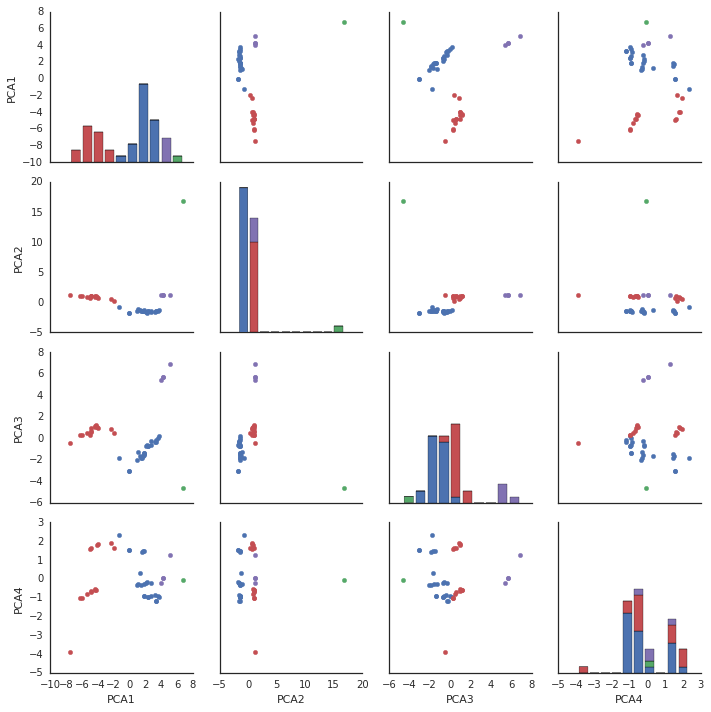

In [9]:
k_means, clusters = cluster(reduced, random_state=check_random_state(0), n_clusters=4)
pg = plot_pair(reduced, clusters)

We can see that the one outlier is in its own cluster, there’s 3 or 4 in the other and the remainder are split into two clusters of greater size.

In [10]:
assert_is_instance(pg.fig, plt.Figure)
assert_true(len(pg.data.columns) >= 4)

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 4 * 10) # 4 clusters with 10 patches in each histogram

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_out, y_out = ax.collections[0].get_offsets().T
    x_in = reduced[clusters == 0, j] # we only check the first cluster
    y_in = reduced[clusters == 0, i]
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = reduced[clusters == 0, j]
    y_in = reduced[clusters == 0, i]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

## More discussion

You don't have to write any code in this section, but here's one interpretaion of what we have done.

Let's take a closer look at each cluster.

In [11]:
df = pd.read_csv('/home/data_scientist/data/delta.csv', index_col='Aircraft')
df['Clusters'] = clusters
df['Aircraft'] = df.index
df_grouped = df.groupby('Clusters').mean()
print(df_grouped.Accommodation)

Clusters
0    153.625000
1    244.733333
2     44.500000
3     54.000000
Name: Accommodation, dtype: float64


In [12]:
print(df_grouped['Length (ft)'])

Clusters
0    137.048083
1    190.538400
2     84.810750
3    111.000000
Name: Length (ft), dtype: float64


Cluster 3 has only one aircraft:

In [13]:
clust3 = df[df.Clusters == 3]
print(clust3.Aircraft)

Aircraft
Airbus A319 VIP    Airbus A319 VIP
Name: Aircraft, dtype: object


Airbus A319 VIP is not one of Delta Airline's regular fleet and is one of Airbus corporate jets.

Cluster 2 has four aircrafts.

In [14]:
clust2 = df[df.Clusters == 2]
print(clust2.Aircraft)

Aircraft
CRJ 100/200 Pinnacle/SkyWest    CRJ 100/200 Pinnacle/SkyWest
CRJ 100/200 ExpressJet                CRJ 100/200 ExpressJet
E120                                                    E120
ERJ-145                                              ERJ-145
Name: Aircraft, dtype: object


These are small aircrafts and only have economy seats.

In [15]:
cols_seat = ['First Class', 'Business', 'Eco Comfort', 'Economy']
print(df.loc[clust2.index, cols_seat])

                              First Class  Business  Eco Comfort  Economy
Aircraft                                                                 
CRJ 100/200 Pinnacle/SkyWest            0         0            0        1
CRJ 100/200 ExpressJet                  0         0            0        1
E120                                    0         0            0        1
ERJ-145                                 0         0            0        1


Next, we look at Cluster 1.

In [16]:
clust1 = df[df.Clusters == 1]
print(clust1.Aircraft)

Aircraft
Airbus A330-200                      Airbus A330-200
Airbus A330-200 (3L2)          Airbus A330-200 (3L2)
Airbus A330-200 (3L3)          Airbus A330-200 (3L3)
Airbus A330-300                      Airbus A330-300
Boeing 747-400 (74S)            Boeing 747-400 (74S)
Boeing 757-200 (75E)            Boeing 757-200 (75E)
Boeing 757-200 (75X)            Boeing 757-200 (75X)
Boeing 767-300 (76G)            Boeing 767-300 (76G)
Boeing 767-300 (76L)            Boeing 767-300 (76L)
Boeing 767-300 (76T)            Boeing 767-300 (76T)
Boeing 767-300 (76Z V.1)    Boeing 767-300 (76Z V.1)
Boeing 767-300 (76Z V.2)    Boeing 767-300 (76Z V.2)
Boeing 767-400 (76D)            Boeing 767-400 (76D)
Boeing 777-200ER                    Boeing 777-200ER
Boeing 777-200LR                    Boeing 777-200LR
Name: Aircraft, dtype: object


These aircrafts do not have first class seating.

In [17]:
print(df.loc[clust1.index, cols_seat])

                          First Class  Business  Eco Comfort  Economy
Aircraft                                                             
Airbus A330-200                     0         1            1        1
Airbus A330-200 (3L2)               0         1            1        1
Airbus A330-200 (3L3)               0         1            1        1
Airbus A330-300                     0         1            1        1
Boeing 747-400 (74S)                0         1            1        1
Boeing 757-200 (75E)                0         1            1        1
Boeing 757-200 (75X)                0         1            1        1
Boeing 767-300 (76G)                0         1            1        1
Boeing 767-300 (76L)                0         1            1        1
Boeing 767-300 (76T)                0         1            1        1
Boeing 767-300 (76Z V.1)            0         1            1        1
Boeing 767-300 (76Z V.2)            0         1            1        1
Boeing 767-400 (76D)

Finally, cluster 0 has the following aircrafts:

In [18]:
clust0 = df[df.Clusters == 0]
print(clust0.Aircraft)

Aircraft
Airbus A319                          Airbus A319
Airbus A320                          Airbus A320
Airbus A320 32-R                Airbus A320 32-R
Boeing 717                            Boeing 717
Boeing 737-700 (73W)        Boeing 737-700 (73W)
Boeing 737-800 (738)        Boeing 737-800 (738)
Boeing 737-800 (73H)        Boeing 737-800 (73H)
Boeing 737-900ER (739)    Boeing 737-900ER (739)
Boeing 757-200 (75A)        Boeing 757-200 (75A)
Boeing 757-200 (75M)        Boeing 757-200 (75M)
Boeing 757-200 (75N)        Boeing 757-200 (75N)
Boeing 757-200 (757)        Boeing 757-200 (757)
Boeing 757-200 (75V)        Boeing 757-200 (75V)
Boeing 757-300                    Boeing 757-300
Boeing 767-300 (76P)        Boeing 767-300 (76P)
Boeing 767-300 (76Q)        Boeing 767-300 (76Q)
Boeing 767-300 (76U)        Boeing 767-300 (76U)
CRJ 700                                  CRJ 700
CRJ 900                                  CRJ 900
E170                                        E170
E175       

The aircrafts in cluster 0 (except for one aircraft) have first class seating but no business class.

In [19]:
print(df.loc[clust0.index, cols_seat])

                        First Class  Business  Eco Comfort  Economy
Aircraft                                                           
Airbus A319                       1         0            1        1
Airbus A320                       1         0            1        1
Airbus A320 32-R                  1         0            1        1
Boeing 717                        1         0            1        1
Boeing 737-700 (73W)              1         0            1        1
Boeing 737-800 (738)              1         0            1        1
Boeing 737-800 (73H)              1         0            1        1
Boeing 737-900ER (739)            1         0            1        1
Boeing 757-200 (75A)              1         0            1        1
Boeing 757-200 (75M)              1         0            1        1
Boeing 757-200 (75N)              1         0            1        1
Boeing 757-200 (757)              1         0            1        1
Boeing 757-200 (75V)              1         0   